<h3>Importing all the required libraries</h3>

In [1]:
import pandas as pd
from scipy.io import arff
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

In [2]:
plt.rcParams['font.family'] = 'Ubuntu Mono'

<h3>Loading Bank Data into Pandas Dataframe</h3>

In [3]:
bank_data = arff.loadarff('Datasets/bank-additional-ful-nominal.arff')
bank_data_df= pd.DataFrame(bank_data[0])
bank_data_df.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
0,b'housemaid',b'married',b'basic.4y',b'no',b'no',b'no',b'telephone',b'may',b'mon',b'nonexistent',b'no'
1,b'services',b'married',b'high.school',b'unknown',b'no',b'no',b'telephone',b'may',b'mon',b'nonexistent',b'no'
2,b'services',b'married',b'high.school',b'no',b'yes',b'no',b'telephone',b'may',b'mon',b'nonexistent',b'no'
3,b'admin.',b'married',b'basic.6y',b'no',b'no',b'no',b'telephone',b'may',b'mon',b'nonexistent',b'no'
4,b'services',b'married',b'high.school',b'no',b'no',b'yes',b'telephone',b'may',b'mon',b'nonexistent',b'no'


<h3>Converting Numpy bytes in Dataframe to Strings</h3>

In [4]:
bank_data_df = bank_data_df.map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
bank_data_df.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,no
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent,no
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent,no
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent,no
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent,no


<h3>Checking if there are any Null values in the dataset</h3>

In [5]:
print(bank_data_df.isnull().sum())

job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
poutcome       0
y              0
dtype: int64


In [6]:
bank_data_df.rename(columns={'y':'anomaly'}, inplace=True)
bank_data_df['anomaly'] = bank_data_df['anomaly'].map({'no':0,'yes':1})
bank_data_df.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,anomaly
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,0
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent,0
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent,0
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent,0
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent,0


<h3>Checking the Number of Anomalies and Non-anomalies</h3>

In [7]:
print(bank_data_df['anomaly'].value_counts())

anomaly
0    36548
1     4640
Name: count, dtype: int64


<h3>Label Encoding the Data to apply SMOTE(Synthetic Minority Oversampling Technique)</h3>

In [8]:
X = bank_data_df.iloc[:, :-1]
y = bank_data_df['anomaly']

label_encoders = {}
X_encoded = X.copy()
for col in X_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    label_encoders[col] = le

X_encoded.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,3,1,0,0,0,0,1,6,1,1
1,7,1,3,1,0,0,1,6,1,1
2,7,1,3,0,2,0,1,6,1,1
3,0,1,1,0,0,0,1,6,1,1
4,7,1,3,0,0,2,1,6,1,1


<h3>Applying SMOTE to balance the dataset</h3>

In [9]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled = pd.Series(y_resampled, name='anomaly')

<h3>Target Encoding the Features</h3>

In [10]:
target_encoder = ce.TargetEncoder(cols=X.columns)
X_anomaly_encoded = target_encoder.fit_transform(X_resampled, y_resampled)

bank_data_df = pd.concat([X_anomaly_encoded, y_resampled], axis=1)
bank_data_df.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,anomaly
0,0.450777,0.494436,0.498997,0.552270,0.494764,0.508226,0.197015,0.362165,0.468824,0.454148,0
1,0.418501,0.494436,0.467687,0.157819,0.494764,0.508226,0.197015,0.362165,0.468824,0.454148,0
2,0.418501,0.494436,0.467687,0.552270,0.504611,0.508226,0.197015,0.362165,0.468824,0.454148,0
3,0.555588,0.494436,0.403459,0.552270,0.494764,0.508226,0.197015,0.362165,0.468824,0.454148,0
4,0.418501,0.494436,0.467687,0.552270,0.494764,0.449609,0.197015,0.362165,0.468824,0.454148,0


<h3>Checking the Number of Anomalies and Non-anomalies</h3>

In [11]:
print(bank_data_df['anomaly'].value_counts())

anomaly
0    36548
1    36548
Name: count, dtype: int64


<h3>Scaling the Data using Standard Scaler</h3>

In [12]:
anomaly_column = bank_data_df['anomaly']
columns_to_scale = bank_data_df.drop(columns = ['anomaly'])

scaler = StandardScaler()
scaled_data = scaler.fit_transform(columns_to_scale)
bank_data_df = pd.DataFrame(scaled_data, columns=columns_to_scale.columns, index = bank_data_df.index)
bank_data_df['anomaly'] = anomaly_column

bank_data_df.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,anomaly
0,-0.436434,-0.359338,-0.017154,0.390780,-1.074351,0.407168,-1.765481,-0.85975,-0.867261,-0.415953,0
1,-0.722613,-0.359338,-0.554870,-2.559185,-1.074351,0.407168,-1.765481,-0.85975,-0.867261,-0.415953,0
2,-0.722613,-0.359338,-0.554870,0.390780,0.946113,0.407168,-1.765481,-0.85975,-0.867261,-0.415953,0
3,0.492873,-0.359338,-1.657915,0.390780,-1.074351,0.407168,-1.765481,-0.85975,-0.867261,-0.415953,0
4,-0.722613,-0.359338,-0.554870,0.390780,-1.074351,-2.494166,-1.765481,-0.85975,-0.867261,-0.415953,0


<h3>Checking if there's any Correlation between features</h3>

[]


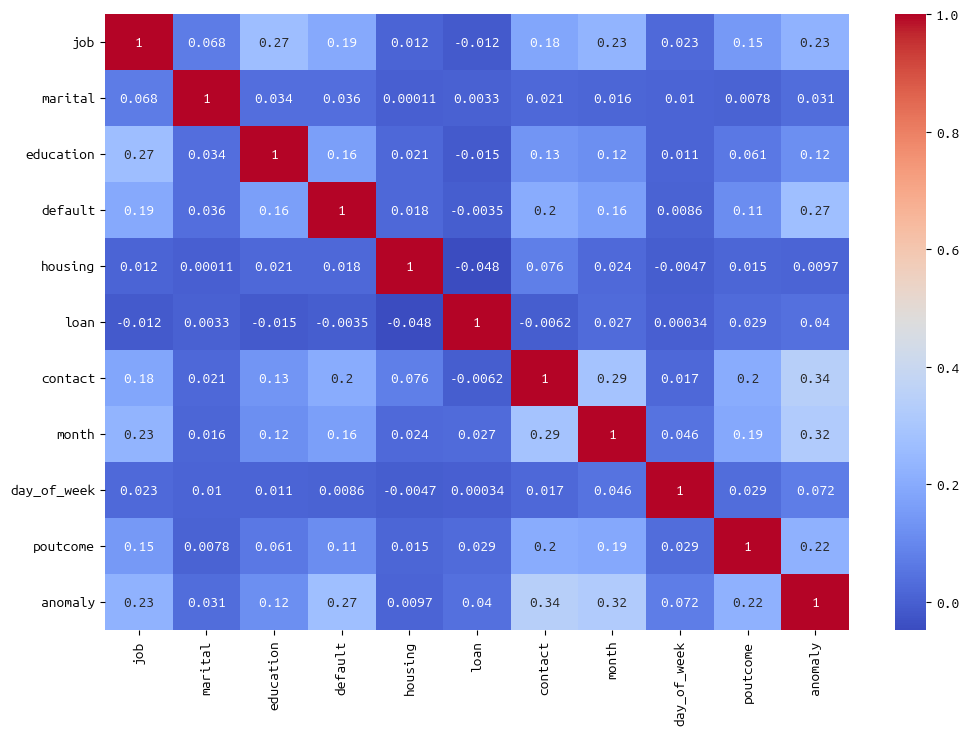

In [13]:
corr_matrix = bank_data_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

high_corr_pairs = np.where(np.abs(corr_matrix) > 0.8)
high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_pairs) if x != y and x < y]
print(high_corr_pairs)

<h3>Features Dimensionality Reduction using PCA(Principal Component Analysis)</h3>

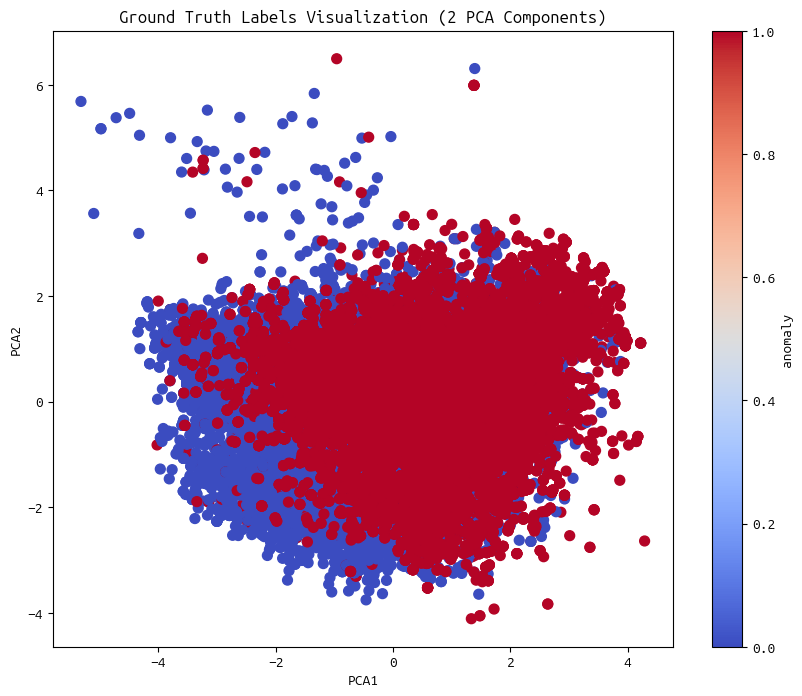

In [14]:
X = bank_data_df.iloc[:, :-1]
y = (bank_data_df['anomaly'] == 1).astype(int)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_df['anomaly'] = y

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df['anomaly'], cmap='coolwarm', s=50)
plt.title("Ground Truth Labels Visualization (2 PCA Components)")
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(scatter, label='anomaly')
plt.show()

<h3>Predicting Anomalies using Random Forest and K-Nearest Neighbours Algorithms</h3>


--- Random Forest ---
Accuracy: 0.81
Confusion Matrix:
[[5638 1672]
 [1128 6182]]
Precision: 0.79, Recall: 0.85, F1-Score: 0.82
Matthews Correlation Coefficient (MCC): 0.62


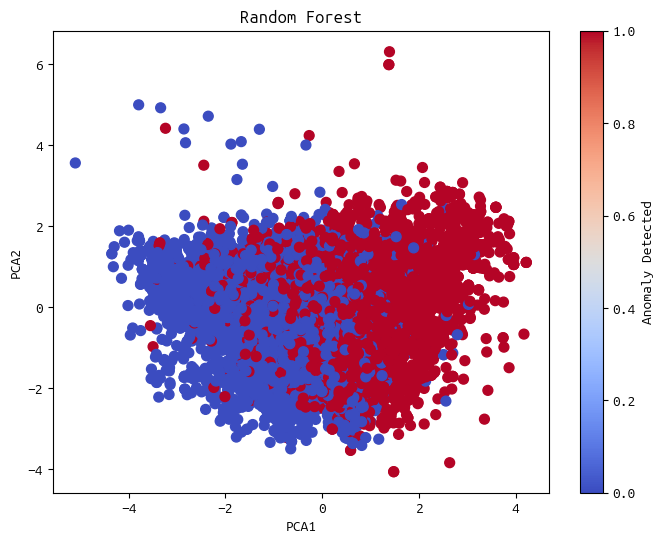


--- k-NN ---
Accuracy: 0.77
Confusion Matrix:
[[5310 2000]
 [1407 5903]]
Precision: 0.75, Recall: 0.81, F1-Score: 0.78
Matthews Correlation Coefficient (MCC): 0.54


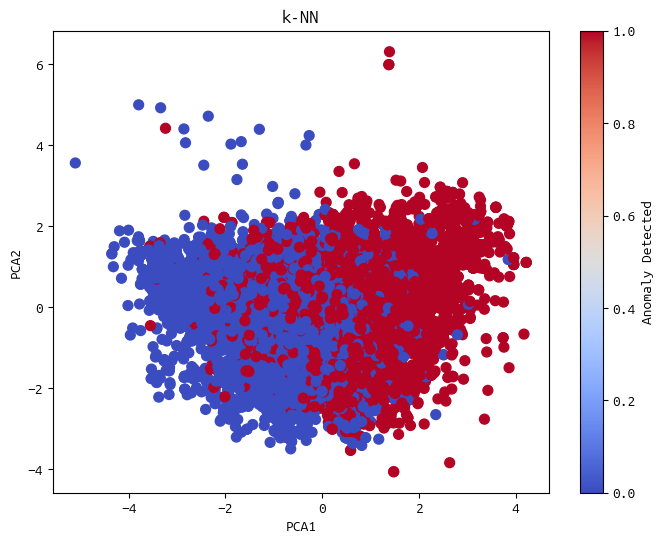

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "k-NN": KNeighborsClassifier(n_neighbors=5)
}

for model_name, model in models.items():
    print(f"\n--- {model_name} ---")
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}")
    
    anomaly_labels = (y_pred == 1).astype(int)
    plt.figure(figsize=(8, 6))
    plt.scatter(X_test[:, 0], X_test[:, 1], c=anomaly_labels, cmap='coolwarm', s=50)
    plt.title(f'{model_name}')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.colorbar(label='Anomaly Detected')
    plt.show()